In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, fbeta_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from xgboost import XGBClassifier

np.set_printoptions(suppress=True)

%matplotlib inline

In [2]:
def vcounts(col):
    df = (loans[col].value_counts(dropna=False)
          .rename("count")
          .reset_index())
    df['pct'] = df['count'] / df['count'].sum()
    return df

In [3]:
def APRF(act, pred, th = 0.5, title=''):
    print(title)
    plt.figure(figsize=(8,10))
    cm = confusion_matrix(act, pred)
    sns.heatmap(cm, cmap='Blues', square=True,
                annot=True, fmt='d',
               xticklabels=['No Default', 'Default'],
               yticklabels=['No Default', 'Default'])
    plt.title("Confusion Matrix - Logistic Regression ")
    plt.ylabel("Defaults Actual")
    plt.xlabel("Defaults Predicted")
    print("Accuracy:  {}".format(accuracy_score(act, pred)))
    print("Precision: {}".format(precision_score(act, pred)))
    print("Recall:    {}".format(recall_score(act, pred)))
    print("F1:        {}".format(f1_score(act, pred)))
    plt.savefig('example.png')
    

In [411]:
def APRF2(act_t, pred_t, act_v, pred_v, th = 0.5, title=''):
    print(title)
    plt.figure(figsize=(6,6))
    
    plt.subplot(2,1,1)
    cm = confusion_matrix(act_t, pred_t)
    sns.heatmap(cm, cmap='Blues', square=True,
                annot=True, fmt='d',
               xticklabels=['No Default', 'Default'],
               yticklabels=['No Default', 'Default'])
    plt.title("Confusion Matrix")
    plt.ylabel("Defaults Actual")
    plt.xlabel("Defaults Predicted")
    
    plt.subplot(2,1,2)
    cm = confusion_matrix(act_v, pred_v)
    sns.heatmap(cm, cmap='Reds', square=True,
                annot=True, fmt='d',
               xticklabels=['No Default', 'Default'],
               yticklabels=['No Default', 'Default'])
    plt.title("Confusion Matrix")
    plt.ylabel("Defaults Actual")
    plt.xlabel("Defaults Predicted")
    
    plt.tight_layout()
    
    print("Training:")
    print("Accuracy:  {}".format(accuracy_score(act_t, pred_t)))
    print("Precision: {}".format(precision_score(act_t, pred_t, zero_division=0)))
    print("Recall:    {}".format(recall_score(act_t, pred_t, zero_division=0)))
    print("F1:        {}".format(f1_score(act_t, pred_t)))
    print("Fbeta:     {}".format(fbeta_score(act_t, pred_t, beta =2 )))
    print()
    print("Validation:")
    print("Accuracy:  {}".format(accuracy_score(act_v, pred_v)))
    print("Precision: {}".format(precision_score(act_v, pred_v, zero_division=0)))
    print("Recall:    {}".format(recall_score(act_v, pred_v, zero_division=0)))
    print("F1:        {}".format(f1_score(act_v, pred_v)))
    print("Fbeta:     {}".format(fbeta_score(act_v, pred_v, beta=2)))

    

In [43]:
loans = pd.read_csv('lc_loan.csv')
#loans2 = pd.read_csv('lc_2016_2017.csv')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Defining y

The target variable will be binary - default or no default. 

Loans with `loan_status == 'Charged Off'` will be set to 1
All other loans will be set to 0

In [44]:
loans.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [45]:
#Single 
mapper = {True:1, False:0}
loans["y"] = loans.loan_status == "Charged Off"
loans["y"] = loans.y.map(mapper)
y = loans['y']

In [46]:
loans.y.value_counts(dropna = False)

0    842131
1     45248
Name: y, dtype: int64

# EDA on Features / Target interaction

<AxesSubplot:xlabel='loan_amnt', ylabel='Density'>

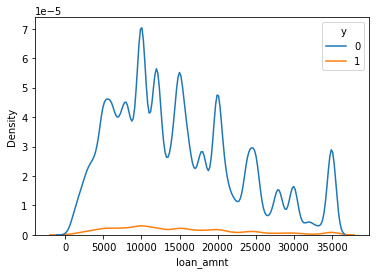

In [47]:
sns.kdeplot(data=loans, x='loan_amnt', hue='y')

In [48]:
#Cols preprocessing
loans.home_ownership.value_counts(dropna=False)


MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64

In [49]:
mapper = {'MORTGAGE':'MORTGAGE',
          'RENT':'RENT',
          'OWN':'OWN',
          'NONE':'OTHER',
          'ANY':'OTHER',
          'OTHER':'OTHER'}
loans['home_ownership2'] = loans['home_ownership'].map(mapper)

In [50]:
loans.home_ownership2.isna().sum()

0

**Feature:** Term

In [51]:
loans.term.value_counts(dropna = False)

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [52]:
mapper = {'36 months' : 0,
          '60 months' : 1}
loans["term2"] = loans.term.str.strip()
loans["term2"] = loans.term2.map(mapper)

In [53]:
loans.term2.value_counts()

0    621125
1    266254
Name: term2, dtype: int64

**Feature:** Open Accounts

<AxesSubplot:xlabel='open_acc', ylabel='Density'>

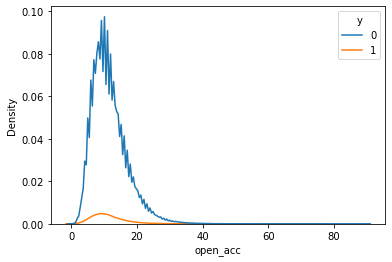

In [54]:
sns.kdeplot(data=loans, x='open_acc', hue='y')

In [55]:
loans.open_acc.value_counts(dropna=False)

9.0     80285
10.0    78321
8.0     76578
11.0    72265
7.0     67896
        ...  
67.0        1
64.0        1
90.0        1
57.0        1
74.0        1
Name: open_acc, Length: 78, dtype: int64

**Feature:** Grade

In [564]:
loans.mths_since_last_delinq.value_counts(dropna=False)

NaN      454312
9.0        8591
6.0        8470
12.0       8368
8.0        8335
          ...  
180.0         1
124.0         1
159.0         1
140.0         1
136.0         1
Name: mths_since_last_delinq, Length: 156, dtype: int64

<AxesSubplot:xlabel='mths_since_last_delinq', ylabel='Density'>

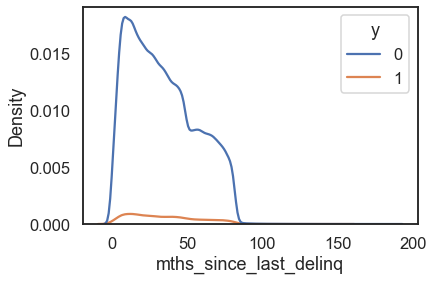

In [566]:
sns.kdeplot(data=loans, x='mths_since_last_delinq', hue='y')

**Feature:** Verification Status

In [58]:
loans.verification_status.value_counts(dropna=False)

Source Verified    329558
Verified           291071
Not Verified       266750
Name: verification_status, dtype: int64

<AxesSubplot:xlabel='verification_status', ylabel='count'>

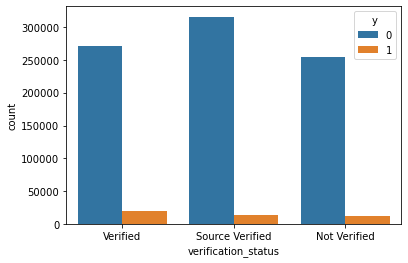

In [59]:
sns.countplot(data=loans, x='verification_status', hue='y')

(0.0, 20000.0)

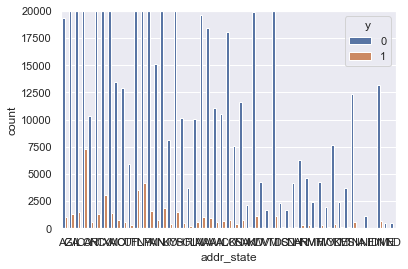

In [500]:
sns.countplot(data=loans, x='addr_state', hue='y')
plt.ylim((0,20000))


In [61]:
loans[['purpose','y']].value_counts().sort_index()

purpose             y
car                 0      8415
                    1       448
credit_card         0    198356
                    1      7826
debt_consolidation  0    496616
                    1     27599
educational         0       367
                    1        56
home_improvement    0     49560
                    1      2269
house               0      3421
                    1       286
major_purchase      0     16403
                    1       874
medical             0      7971
                    1       569
moving              0      4989
                    1       425
other               0     39958
                    1      2936
renewable_energy    0       521
                    1        54
small_business      0      9006
                    1      1371
vacation            0      4466
                    1       270
wedding             0      2082
                    1       265
dtype: int64

In [62]:
vcounts('purpose')

,index,count,pct
0,debt_consolidation,524215,0.590745
1,credit_card,206182,0.232349
2,home_improvement,51829,0.058407
3,other,42894,0.048338
4,major_purchase,17277,0.019470
5,small_business,10377,0.011694
6,car,8863,0.009988
7,medical,8540,0.009624
8,moving,5414,0.006101
9,vacation,4736,0.005337


(0.0, 10.0)

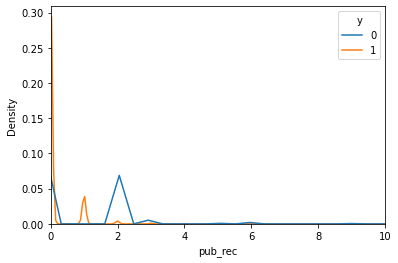

In [236]:
sns.kdeplot(data=loans, x='pub_rec', hue='y')
plt.xlim((0,10))

<AxesSubplot:xlabel='total_acc', ylabel='Density'>

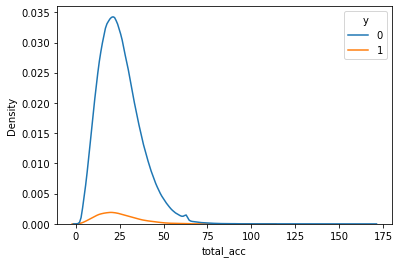

In [233]:
sns.kdeplot(data=loans, x='total_acc', hue='y')


<AxesSubplot:xlabel='inq_last_6mths', ylabel='Density'>

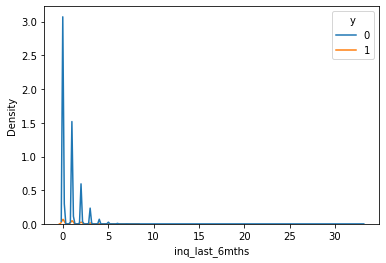

In [237]:
sns.kdeplot(data=loans, x='inq_last_6mths', hue='y')


<AxesSubplot:xlabel='all_util', ylabel='y'>

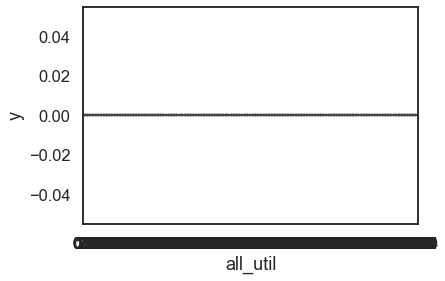

In [559]:
sns.boxplot(data=loans, x='all_util', y='y')

<AxesSubplot:xlabel='y', ylabel='dti'>

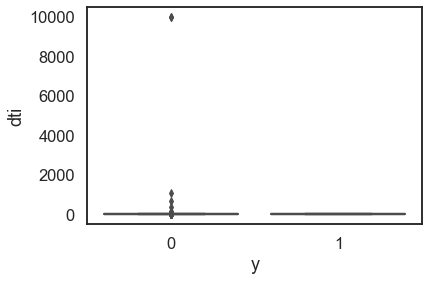

In [558]:
sns.boxplot(data=loans, x='y', y='dti')

In [563]:
sum(loans.dti.isna())

0

## Base features

In [331]:
# X_NUM = ['loan_amnt', 'int_rate', 'annual_inc', 'revol_util', 'delinq_2yrs',
#          'term2']

X_NUM = ['loan_amnt', 'annual_inc', 'revol_util', 'delinq_2yrs', 
         'term2',
         'open_acc',
         'total_acc',
         'pub_rec', 
         'inq_last_6mths']
        
X_CATEGORIES = ['home_ownership2', 'verification_status', 'purpose', 'addr_state']
X_COLUMNS = X_NUM + X_CATEGORIES
X_COLUMNS

['loan_amnt',
 'annual_inc',
 'revol_util',
 'delinq_2yrs',
 'term2',
 'open_acc',
 'total_acc',
 'pub_rec',
 'inq_last_6mths',
 'home_ownership2',
 'verification_status',
 'purpose',
 'addr_state']

In [332]:
X = loans[X_COLUMNS].copy()

annual_inc_mean = X.annual_inc.mean()
X.annual_inc.fillna(annual_inc_mean, inplace=True)

annual_revol_util = X.revol_util.mean()
X.revol_util.fillna(annual_revol_util, inplace=True)

#annual_revol_util = X.revol_util.mean()
X.delinq_2yrs.fillna(0, inplace=True)

X.inq_last_6mths.fillna(0, inplace=True)
X.total_acc.fillna(0, inplace=True)
X.pub_rec.fillna(0, inplace=True)
X.open_acc.fillna(0, inplace=True)




# annual_inc_mean = X.annual_inc.mean()
# X.annual_inc.fillna(annual_inc_mean, inplace=True)

# annual_inc_mean = X.annual_inc.mean()
# X.annual_inc.fillna(annual_inc_mean, inplace=True)

# annual_inc_mean = X.annual_inc.mean()
# X.annual_inc.fillna(annual_inc_mean, inplace=True)



X = pd.get_dummies(X, columns = X_CATEGORIES, drop_first=True)

X.columns

Index(['loan_amnt', 'annual_inc', 'revol_util', 'delinq_2yrs', 'term2',
       'open_acc', 'total_acc', 'pub_rec', 'inq_last_6mths',
       'home_ownership2_OTHER', 'home_ownership2_OWN', 'home_ownership2_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA',
       'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL',
       'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA',
       'addr_state_MA', 'addr_state_MD', 'addr_

In [333]:
def getdummycols(df, inlist):
    newl = []
    for s in inlist:
        newl.extend(list(df.columns[df.columns.str.startswith(s)]))
    return newl

#getdummycols(X, ['addr_', 'purpose_',])

In [449]:
with open('X_base.pkl', "wb") as file:
    pickle.dump(X, file)
with open('y_base.pkl', "wb") as file:
    pickle.dump(y, file)


# Extra Features

In [567]:
# X_NUM = ['loan_amnt', 'int_rate', 'annual_inc', 'revol_util', 'delinq_2yrs',
#          'term2']

X_NUM = ['loan_amnt', 'annual_inc', 'revol_util', 'delinq_2yrs', 
         'term2',
         'open_acc',
         'total_acc',
         'pub_rec', 
          'dti',
          'mths_since_last_delinq',
         'inq_last_6mths']
        
X_CATEGORIES = ['home_ownership2', 'verification_status', 'purpose',
                'addr_state', 'zip_code', 'emp_length']
X_COLUMNS = X_NUM + X_CATEGORIES
X_COLUMNS

['loan_amnt',
 'annual_inc',
 'revol_util',
 'delinq_2yrs',
 'term2',
 'open_acc',
 'total_acc',
 'pub_rec',
 'dti',
 'mths_since_last_delinq',
 'inq_last_6mths',
 'home_ownership2',
 'verification_status',
 'purpose',
 'addr_state',
 'zip_code',
 'emp_length']

In [568]:
X = loans[X_COLUMNS].copy()

annual_inc_mean = X.annual_inc.mean()
X.annual_inc.fillna(annual_inc_mean, inplace=True)

annual_revol_util = X.revol_util.mean()
X.revol_util.fillna(annual_revol_util, inplace=True)

#annual_revol_util = X.revol_util.mean()
X.delinq_2yrs.fillna(0, inplace=True)

X.inq_last_6mths.fillna(0, inplace=True)
X.total_acc.fillna(0, inplace=True)
X.pub_rec.fillna(0, inplace=True)
X.open_acc.fillna(0, inplace=True)

X.mths_since_last_delinq.fillna(0, inplace=True)


# annual_inc_mean = X.annual_inc.mean()
# X.annual_inc.fillna(annual_inc_mean, inplace=True)

# annual_inc_mean = X.annual_inc.mean()
# X.annual_inc.fillna(annual_inc_mean, inplace=True)

# annual_inc_mean = X.annual_inc.mean()
# X.annual_inc.fillna(annual_inc_mean, inplace=True)



X = pd.get_dummies(X, columns = X_CATEGORIES, drop_first=True)

X.columns

Index(['loan_amnt', 'annual_inc', 'revol_util', 'delinq_2yrs', 'term2',
       'open_acc', 'total_acc', 'pub_rec', 'dti', 'mths_since_last_delinq',
       ...
       'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
       'emp_length_< 1 year'],
      dtype='object', length=1023)

In [569]:
def getdummycols(df, inlist):
    newl = []
    for s in inlist:
        newl.extend(list(df.columns[df.columns.str.startswith(s)]))
    return newl

#getdummycols(X, ['addr_', 'purpose_',])

In [570]:
with open('X_xtra1.pkl', "wb") as file:
    pickle.dump(X, file)
with open('y_xtra1.pkl', "wb") as file:
    pickle.dump(y, file)


# Files saved above are loaded in the `model_v1` and `model_extra1` notebooks where the models are executed

## Additional EDA / scratch work below


# Create splits

Use `stratify=y`

In [571]:
vcounts('y')

,index,count,pct
0,0,842131,0.949009
1,1,45248,0.050991


In [572]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=2019)


In [573]:
y_train.value_counts(dropna = False)

0    505279
1     27148
Name: y, dtype: int64

In [574]:
y_test.value_counts(dropna=False)

0    168426
1      9050
Name: y, dtype: int64

Dummy - Train
Training:
Accuracy:  0.949010850313752
Precision: 0.0
Recall:    0.0
F1:        0.0
Fbeta:     0.0

Validation:
Accuracy:  0.9490071897045235
Precision: 0.0
Recall:    0.0
F1:        0.0
Fbeta:     0.0


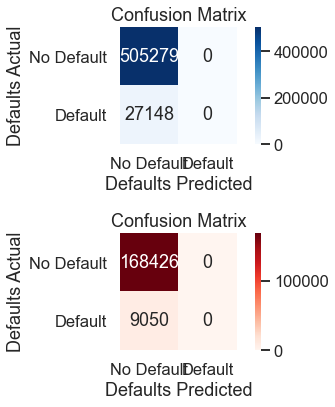

In [575]:
dum = DummyClassifier(strategy="most_frequent")
dum.fit(X_train, y_train)
y_pred_dum = dum.predict(X_train)
y_pred_dum2 = dum.predict(X_val)

APRF2(y_train, y_pred_dum, y_val, y_pred_dum2, title = "Dummy - Train")


In [440]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()


Training:
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1:        1.0
Fbeta:     1.0

Validation:
Accuracy:  0.8975467105411435
Precision: 0.07134140617666385
Recall:    0.08397790055248619
F1:        0.07714561234329798
Fbeta:     0.08110473182080122


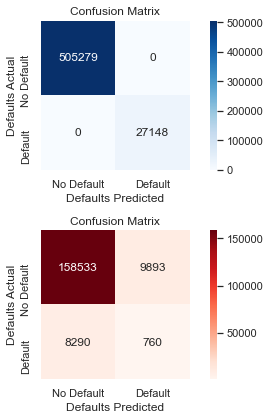

In [441]:
y_preds_tree = dt.predict(X_train)
y_preds_tree2 = dt.predict(X_val)

APRF2(y_train, y_preds_tree, y_val, y_preds_tree2 )

In [443]:
plot_tree(dt)

[Text(230.26541140985063, 215.34923076923076, 'X[8] <= 1.5\ngini = 0.097\nsamples = 532427\nvalue = [505279, 27148]'),
 Text(150.58965278328563, 211.1676923076923, 'X[1] <= 61801.5\ngini = 0.086\nsamples = 443678\nvalue = [423777, 19901]'),
 Text(91.1047320687008, 206.98615384615385, 'X[2] <= 61.45\ngini = 0.106\nsamples = 214053\nvalue = [202013, 12040]'),
 Text(63.228226274180585, 202.80461538461537, 'X[24] <= 0.5\ngini = 0.09\nsamples = 127904\nvalue = [121868, 6036]'),
 Text(47.621798445532185, 198.62307692307692, 'X[8] <= 0.5\ngini = 0.088\nsamples = 126562\nvalue = [120705, 5857]'),
 Text(29.812864910084638, 194.44153846153847, 'X[13] <= 0.5\ngini = 0.078\nsamples = 83141\nvalue = [79766, 3375]'),
 Text(18.832045924018615, 190.26, 'X[1] <= 45831.5\ngini = 0.07\nsamples = 61353\nvalue = [59115, 2238]'),
 Text(10.294290287678812, 186.07846153846154, 'X[11] <= 0.5\ngini = 0.082\nsamples = 33324\nvalue = [31895, 1429]'),
 Text(4.940852787921986, 181.8969230769231, 'X[0] <= 23437.5\ng

Error in callback <function flush_figures at 0x7fca298cf040> (for post_execute):


KeyboardInterrupt: 

In [434]:
y_train.value_counts()

0    505279
1     27148
Name: y, dtype: int64

In [446]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))

0.9999492888226931



Training:
Accuracy:  0.9999211159464114
Precision: 1.0
Recall:    0.9984529247090025
F1:        0.9992258635307996
Fbeta:     0.9987619566979618

Validation:
Accuracy:  0.9999211159464114
Precision: 1.0
Recall:    0.9984529247090025
F1:        0.9992258635307996
Fbeta:     0.9987619566979618


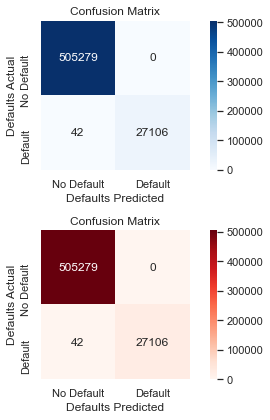

In [431]:
y_preds_rf = rf.predict(X_train)
y_preds_rf2 = rf.predict(X_val)
APRF2(y_train, y_preds_rf, y_val, y_preds_rf2)

In [85]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
knn.score(X_train, y_train)

y_preds_knn = knn.predict(X_train)
y_preds_knn2 = knn.predict(X_val)


APRF2(y_train, y_preds_knn, y_val, y_preds_knn2)


KeyboardInterrupt: 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)

knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train)

y_preds_knn = knn.predict(X_train_scaled)

APRF(y_train, y_preds_knn)


In [342]:
clf = XGBClassifier(use_label_encoder=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

[00:45:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



Training:
Accuracy:  0.9492118168312276
Precision: 0.8962962962962963
Recall:    0.004457050243111832
F1:        0.008869992302899242
Fbeta:     0.005564395228416125

Validation:
Accuracy:  0.9489902860105028
Precision: 0.45454545454545453
Recall:    0.0016574585635359116
F1:        0.0033028734999449526
Fbeta:     0.0020699362459636246


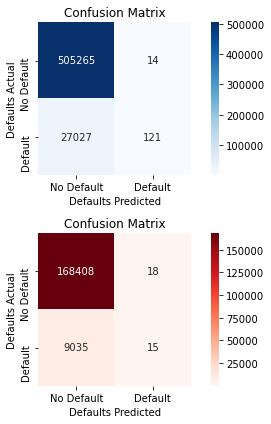

In [343]:
y_pred2 = clf.predict(X_val)

APRF2(y_train, y_pred, y_val, y_pred2)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.18')

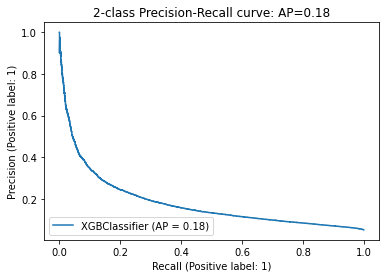

In [346]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_train, clf.predict_proba(X_train)[:,1])

disp = plot_precision_recall_curve(clf, X_train, y_train)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
# ss = StandardScaler()
# X_train_scaled = ss.fit_transform(X_train)

weights = {1:20, 0:1}

lm = LogisticRegression(C=1000, class_weight = weights, max_iter=200)
#lm = LogisticRegression(C=1000)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

lm.fit(X_train_scaled, y_train)

lm.score(X_train_scaled, y_train)

ROC AUC   0.6706032356760118
ROC AUC   0.6706032356760118

Training:
Accuracy:  0.8316670642172542
Precision: 0.10770930918863257
Recall:    0.3159348754972742
F1:        0.1606495659258843
Fbeta:     0.2278414433942717

Validation:
Accuracy:  0.8316670642172542
Precision: 0.10770930918863257
Recall:    0.3159348754972742
F1:        0.1606495659258843
Fbeta:     0.2278414433942717


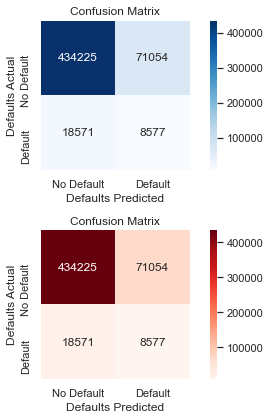

In [402]:
y_preds = lm.predict(X_train_scaled)
y_preds2 = lm.predict(X_val_scaled)

y_preds = lm.predict_proba(X_train_scaled)[:,1] >= 0.625
y_preds2 = lm.predict_proba(X_val_scaled)[:,1] >= 0.625

print('ROC AUC   {}'.format(roc_auc_score(y_train, lm.predict_proba(X_train_scaled)[:,1])))
print('ROC AUC   {}'.format(roc_auc_score(y_val, lm.predict_proba(X_val_scaled)[:,1])))


APRF2(y_train, y_preds, y_val, y_preds2)

Logistic Regression Model best F1 score 0.268 at prob decision threshold >= 0.512


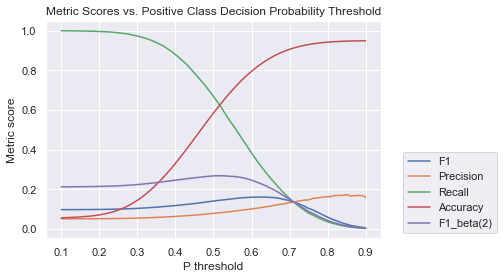

In [405]:
thresh_ps = np.linspace(.10,.90,100)

beta = 2

model_val_probs = lm.predict_proba(X_train_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores, f1b_scores = [], [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_train, model_val_labels))    
    prec_scores.append(precision_score(y_train, model_val_labels))
    rec_scores.append(recall_score(y_train, model_val_labels))
    acc_scores.append(accuracy_score(y_train, model_val_labels))
    f1b_scores.append(fbeta_score(y_train, model_val_labels, beta=2))        
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)
plt.plot(thresh_ps, f1b_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy',f'F1_beta({beta})'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1b_scores) 
best_thresh_p = thresh_ps[np.argmax(f1b_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

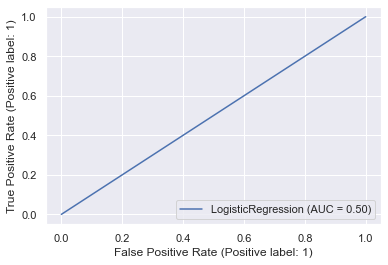

In [367]:
y_pred_proba = lm.predict_proba(X_test)[:,1]
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plot_roc_curve(lm, X_train, y_train)

ROC AUC   0.670669817805761
ROC AUC   0.6745045334597164

Training:
Accuracy:  0.6276578761032029
Precision: 0.08211335648724825
Recall:    0.6191984676587594
F1:        0.14499816703685334
Fbeta:     0.26826551423674394

Validation:
Accuracy:  0.6281412698054948
Precision: 0.0824338593300874
Recall:    0.6211049723756906
F1:        0.1455501178176545
Fbeta:     0.26923592750124536


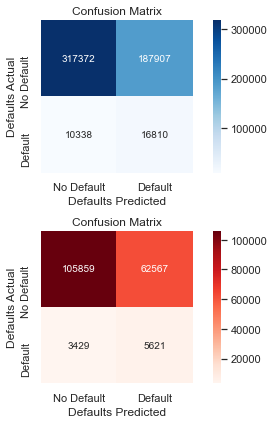

In [445]:
# ss = StandardScaler()
# X_train_scaled = ss.fit_transform(X_train)

lm = LogisticRegression(C=1000, class_weight='balanced' )

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

lm.fit(X_train_scaled, y_train)

lm.score(X_train_scaled, y_train)

y_preds = lm.predict(X_train_scaled)
y_preds2 = lm.predict(X_val_scaled)

print('ROC AUC   {}'.format(roc_auc_score(y_train, lm.predict_proba(X_train_scaled)[:,1])))
print('ROC AUC   {}'.format(roc_auc_score(y_val, lm.predict_proba(X_val_scaled)[:,1])))


APRF2(y_train, y_preds, y_val, y_preds2)

In [202]:
# binary_X = ['term2',
#        'home_ownership2_OTHER', 'home_ownership2_OWN', 'home_ownership2_RENT',
#        'verification_status_Source Verified', 'verification_status_Verified',
#        'purpose_credit_card', 'purpose_debt_consolidation',
#        'purpose_educational', 'purpose_home_improvement', 'purpose_house',
#        'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
#        'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
#        'purpose_vacation', 'purpose_wedding']

binary_X = getdummycols(X, ['addr_', 'purpose_', 'verification_status_','home_ownership2_'])
print(binary_X)

bnb = BernoulliNB()
bnb.fit(X_train[binary_X], y_train)


['addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_ME', 'addr_state_MI', 'addr_state_MN', 'addr_state_MO', 'addr_state_MS', 'addr_state_MT', 'addr_state_NC', 'addr_state_ND', 'addr_state_NE', 'addr_state_NH', 'addr_state_NJ', 'addr_state_NM', 'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OK', 'addr_state_OR', 'addr_state_PA', 'addr_state_RI', 'addr_state_SC', 'addr_state_SD', 'addr_state_TN', 'addr_state_TX', 'addr_state_UT', 'addr_state_VA', 'addr_state_VT', 'addr_state_WA', 'addr_state_WI', 'addr_state_WV', 'addr_state_WY', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'p

BernoulliNB()


Training:
Accuracy:  0.9490089721219999
Precision: 0.0
Recall:    0.0
F1:        0.0
Fbeta:     0.0

Validation:
Accuracy:  0.9490071897045235
Precision: 0.0
Recall:    0.0
F1:        0.0
Fbeta:     0.0


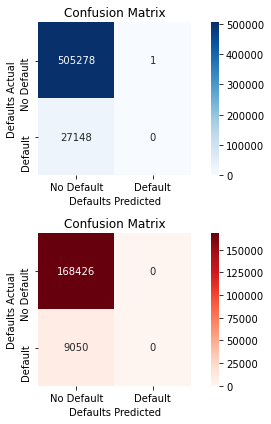

In [356]:
y_preds = bnb.predict(X_train[binary_X])
y_preds2 = bnb.predict(X_val[binary_X])


APRF2(y_train, y_preds, y_val, y_preds2)

In [ ]:
loans.head()

In [ ]:
loans.info()

In [ ]:
loans.open_acc.describe()

In [ ]:
sns.pairplot(loans, )

In [ ]:
sns.boxplot(x='open_acc', hue='loan_status', data = loans)

In [ ]:
loans.home_ownership.value_counts(dropna=False)

In [ ]:
loans.grade.value_counts()

In [ ]:
mapper =  {y:x for x,y in enumerate("ABCDEFG")}
mapper

In [ ]:
loans["grade2"] = loans.grade.map(mapper)

In [ ]:
loans.grade2.value_counts()

In [ ]:
#X = loans.drop(columns="y")
X = loans[['loan_amnt', 'int_rate']] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, loans.y, test_size=0.2, random_state=13)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
def plot_features(df, sample_size=500):
    
#    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
 #               .sample(1000, random_state=44)) 
    sample = df.sample(1000, random_state= 42)
    sns.pairplot(sample, hue='y', plot_kws=dict(alpha=.3, edgecolor='none'))

In [ ]:
plot_features(loans[['y', 'annual_inc', 'delinq_2yrs', 'total_acc', 'revol_util', 'revol_bal']])

In [ ]:
loans.annual_inc.hist(bins= 100)


In [ ]:
loans.annual_inc.value_counts(dropna=False)

In [ ]:
loans.annual_inc.mean()

In [ ]:
loans[loans.y == 0].annual_inc.mean(), loans[loans.y == 1].annual_inc.mean()

In [ ]:
loans[loans.y == 0].total_acc.mean(), loans[loans.y == 1].total_acc.mean()

In [ ]:
loans[loans.y == 0].open_acc.mean(), loans[loans.y == 1].open_acc.mean()

In [ ]:
loans[loans.y == 0].revol_util.mean(), loans[loans.y == 1].revol_util.mean()

In [ ]:
loans[loans.y == 0].delinq_2yrs.mean(), loans[loans.y == 1].delinq_2yrs.mean()

In [1]:
# check split by mean over features
feats = ['annual_inc', 'total_acc', 'open_acc', 'revol_util',
         'delinq_2yrs', 'home_ownership']

print("Feature:\tNonDefault\t\tDefault\t\tAll\t\tDifference")
for i in feats:
    default = np.round(loans[loans.y == 1][i].mean(),2)
    nondefault = np.round(loans[loans.y == 0][i].mean(),2)
    total = np.round(loans[i].mean(),2)
    diff = np.round((default - nondefault) / nondefault,2)
    print(f"'{i}':\t{default}\t\t{nondefault}\t\t{total}\t\t{diff}")
    
    
    

Feature:	NonDefault		Default		All		Difference


NameError: name 'np' is not defined

In [ ]:
loans[['home_ownership','y']].value_counts()

In [ ]:
loans.home_ownership.value_counts(dropna=False)

In [ ]:
mapper = {'MORTGAGE':'MORTGAGE',
          'RENT':'RENT',
          'OWN':'OWN',
          'NONE':'OTHER',
          'ANY':'OTHER',
          'OTHER':'OTHER'}
loans['home_ownership2'] = loans['home_ownership'].map(mapper)

In [ ]:
loans.home_ownership2.value_counts()

In [ ]:
loans[['home_ownership2','y']].value_counts()

In [ ]:
loans[['home_ownership','y']].value_counts()




In [ ]:
sns.kdeplot(data=loans, x='open_acc', hue='y')

In [ ]:
loans.purpose.value_counts(dropna=False)

In [ ]:
sns.countplot(data=loans, y='purpose', hue='y')

In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 73 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            887379 non-null  float64
 1   annual_inc                           887379 non-null  float64
 2   revol_util                           887379 non-null  float64
 3   delinq_2yrs                          887379 non-null  float64
 4   term2                                887379 non-null  int64  
 5   home_ownership2_OTHER                887379 non-null  uint8  
 6   home_ownership2_OWN                  887379 non-null  uint8  
 7   home_ownership2_RENT                 887379 non-null  uint8  
 8   verification_status_Source Verified  887379 non-null  uint8  
 9   verification_status_Verified         887379 non-null  uint8  
 10  purpose_credit_card                  887379 non-null  uint8  
 11  purpose_debt_

In [406]:

import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 10, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

print(X_tr_rs.shape)
print(X_tr_rs.shape)

lr = LogisticRegression(solver='liblinear') 
lr.fit(X_train, y_train)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (fbeta_score(y_tr_rs, lr.predict(X_tr_rs), beta=2), roc_auc_score(y_tr_rs, lr.predict_proba(X_tr_rs)[:,1]))) 
print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (fbeta_score(y_val, lr.predict(X_val), beta=2), roc_auc_score(y_val, lr.predict_proba(X_val)[:,1]))) 



lr_os = LogisticRegression(solver='liblinear') 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (fbeta_score(y_val, lr_os.predict(X_val), beta=2), roc_auc_score(y_val, lr_os.predict_proba(X_val)[:,1])))

(776759, 77)
(776759, 77)
Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.544
Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.544
Logistic Regression on Oversampled Train Data; Test F1: 0.009, Test AUC: 0.595


In [176]:
sum(y_tr_rs)


108592

In [407]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_train, lr_smote.predict(X_train)), roc_auc_score(y_train, lr_smote.predict_proba(X_train)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.007, Test AUC: 0.589



Training:
Accuracy:  0.9487747823523162
Precision: 0.9785107000200834
Recall:    0.8076101370266686
F1:        0.8848843192848278
Fbeta:     0.8368416432249224

Validation:
Accuracy:  0.9439528799253231
Precision: 0.06353322528363047
Recall:    0.0072196846913216445
F1:        0.012965964343598056
Fbeta:     0.008775307359617469


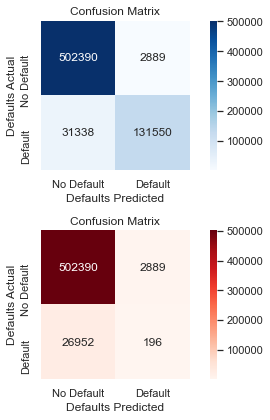

In [425]:
# ss = StandardScaler()
# X_train_scaled = ss.fit_transform(X_train)

#lm = LogisticRegression(C=1000, class_weight='balanced' )
lm = LogisticRegression(C=1000)
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 6, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_tr_smote)
X_val_scaled = ss.transform(X_val)



lm.fit(X_train_scaled, y_tr_smote)

y_preds = lm.predict(X_train_scaled)
y_preds2 = lm.predict(X_val_scaled)


APRF2(y_tr_smote, y_preds, y_val, y_preds2)

In [421]:
y_tr_smote.value_counts()

0    505279
1    108592
Name: y, dtype: int64

In [215]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 77 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [222]:
vcounts('dti')

,index,count,pct
0,19.20,684,0.000771
1,14.40,674,0.000760
2,18.00,661,0.000745
3,13.20,638,0.000719
4,16.80,632,0.000712
...,...,...,...
4081,54.36,1,0.000001
4082,63.64,1,0.000001
4083,42.10,1,0.000001
4084,61.21,1,0.000001


In [221]:
loans[['emp_length','y']].value_counts()

emp_length  y
10+ years   0    278436
2 years     0     74837
< 1 year    0     66752
3 years     0     66492
1 year      0     54131
5 years     0     52501
4 years     0     49754
7 years     0     41992
8 years     0     41801
6 years     0     40255
9 years     0     32880
10+ years   1     13133
2 years     1      4033
< 1 year    1      3853
3 years     1      3534
5 years     1      3203
1 year      1      2964
4 years     1      2775
6 years     1      2695
7 years     1      2602
8 years     1      2154
9 years     1      1777
dtype: int64

In [228]:
vcounts('policy_code')

,index,count,pct
0,1.0,887379,1.0


In [230]:
vcounts('application_type')

,index,count,pct
0,INDIVIDUAL,886868,0.999424
1,JOINT,511,0.000576


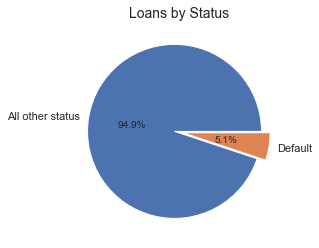

In [527]:
plt.pie(x=y.value_counts(),labels=['All other status', 'Default'],
        explode=[0.05]*2, autopct="%.1f%%", pctdistance=0.5);
plt.title('Loans by Status', fontsize=14)
#plt.xlabel(fontcolor=2)
sns.set_theme('talk')
sns.set_

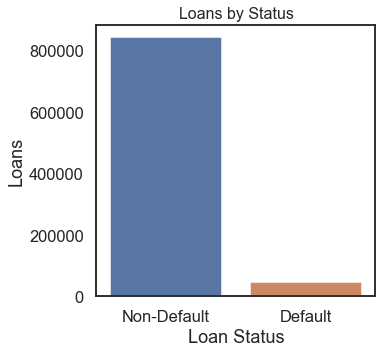

In [540]:
plt.figure(figsize=(5,5))

mapper = {0: "Non-Default", 1:'Default'}
loans['ylabel'] = loans.y.map(mapper)
sns.countplot(data=loans, x='ylabel')
plt.xlabel('Loan Status')
plt.ylabel("Loans")
plt.title('Loans by Status', fontsize=16)
#plt.annotate(xy=(0.70,200000), text=f"High Class\n Imbalance!" )

sns.set_theme('talk')
sns.set_style('white')
plt.savefig("presentation/loans_imbalance.png")


In [469]:
y


0         0
1         1
2         0
3         0
4         0
         ..
887374    0
887375    0
887376    0
887377    0
887378    0
Name: y, Length: 887379, dtype: int64

In [ ]:
#Using matplotlib
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Delivery Tips by type", fontsize=14);
#pie.savefig("DeliveryPieChart.png")

In [507]:
len(loans)


887379

In [508]:
loans.columns.size

78

In [509]:
loans.columns


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

TypeError: value_counts() got an unexpected keyword argument 'dropna'

In [516]:
grp = loans.groupby('zip_code')['zip_code'].count()

In [518]:
grp.sort_values(ascending=False)

zip_code
945xx    9770
750xx    9417
112xx    9272
606xx    8641
300xx    8126
         ... 
909xx       1
621xx       1
643xx       1
649xx       1
514xx       1
Name: zip_code, Length: 935, dtype: int64

In [524]:
grp[grp > 1000]

zip_code
010xx    1477
015xx    1345
017xx    1091
018xx    2214
019xx    1581
         ... 
983xx    2192
984xx    1141
985xx    1252
986xx    1767
995xx    1053
Name: zip_code, Length: 277, dtype: int64

In [549]:
loans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 